In [21]:
import torch
import requests
from models.clipseg import CLIPDensePredT
from PIL import Image, ImageDraw
from torchvision import transforms
from matplotlib import pyplot as plt
import cv2
import numpy as np
from segment_anything import sam_model_registry, SamPredictor

image_path = '/data/rishubh/Raghav/GS/GD/out/images/stool.jpeg'
prompts = ['stool']

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
sam_checkpoint = "/data/rishubh/Raghav/GS/GD/segment-anything/sam_vit_h_4b8939.pth"
model_type = "vit_h"
device = "cuda"
sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)
predictor = SamPredictor(sam)
predictor.set_image(image)


model = CLIPDensePredT(version='ViT-B/16', reduce_dim=64)
model.eval()
model.load_state_dict(torch.load('weights/rd64-uni.pth', map_location=torch.device('cpu')), strict=False)


input_image = Image.open(image_path)
width,height = input_image.size


transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    transforms.Resize((352, 352)),
])
img = transform(input_image).unsqueeze(0)


# predict
with torch.no_grad():
    preds = model(img, prompts)[0]

threshold = 0.99
print("Masking....")
input_point = []
input_label = []
num_point = 0

normalized_preds = (preds - torch.min(preds))/(torch.max(preds)-torch.min(preds))
for col in range(0,len(img[0][0])):
    for row in range(0,len(img[0][0][0])):
        if normalized_preds[0][0][row][col] > threshold:
            input_label.append(1)
            scaled_row = int(row*(width/352))
            scaled_col = int(col*(height/352))
            input_point.append([scaled_col,scaled_row])
            num_point += 1
        if num_point == 1:
            break
    if num_point == 1:
        break
    
input_point = np.array(input_point)
input_label = np.array(input_label)

masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)


#masked_img= Image.open(path)
#masked_img = masked_img.resize((352, 352))
#mask_coordinates = []
#for col in range(0,len(img[0][0])):
#    for row in range(0,len(img[0][0][0])):
#        if preds[0][0][row][col] > threshold:
#            masked_img.putpixel((col, row), (255, 0, 0))
#masked_img.save("/data/rishubh/Raghav/GS/GD/segment-anything/images_seg/New1.png")
#_, ax = plt.subplots(1, 5, figsize=(15, 4))
#[a.axis('off') for a in ax.flatten()]
#ax[0].imshow(input_image)
#ax[1].imshow(torch.sigmoid(preds[0][0])) 
#ax[1].text(0, -15, prompts[0])


Masking....


In [22]:
index = 0
max_segment_area = 0
max_index = 0
for mask in masks:
    mask.sum()
    segment_area = np.count_nonzero(mask)
    if segment_area > max_segment_area:
        segment_area = max_segment_area
        max_index = index
    index = index + 1


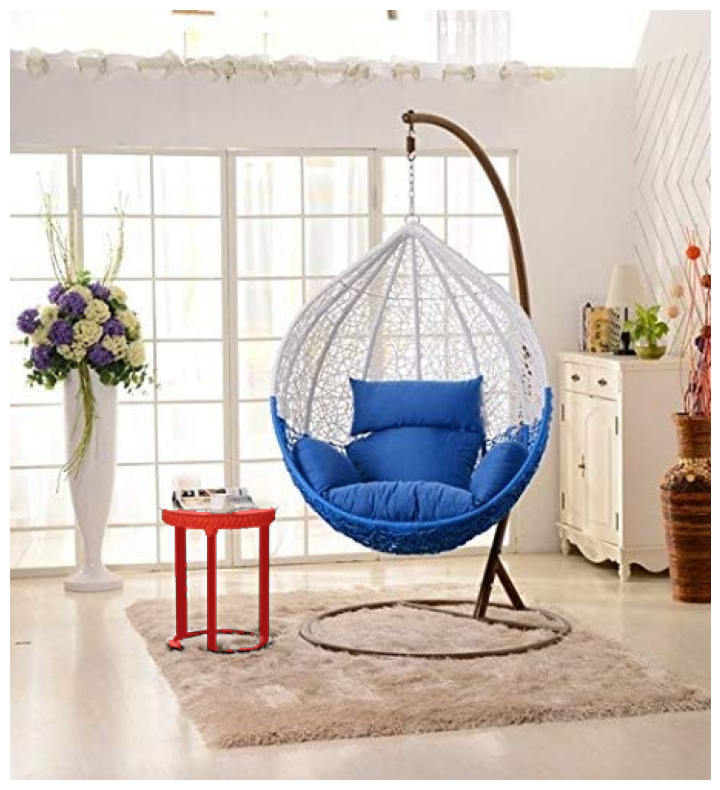

In [23]:
def show_mask(mask, ax):
    color = np.array([255/255, 30/255, 30/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks[max_index], plt.gca())
plt.axis('off')
plt.show()

In [ ]:
image_size = input_image.size
print(image_size)
# Create a new black image
black_image = Image.new("RGB", image_size, color="black")


for col in range(0,len(masks[0])):
    for row in range(0,len(masks[0][0])):
        print(col,row)
        if masks[0][col][row]:
            black_image.putpixel((row+50, col), (255, 255, 255))

# Optionally, you can also display the image
black_image.save("/data/rishubh/Raghav/GS/GD/segment-anything/images_seg/Backpack_seg_shift.png")

In [9]:
print(masks.shape)

(1, 667, 679)
